In [29]:
# Load the final processed dataset
import os
import pandas as pd
FIGURE_PATH = "../Figures/"

DATA_PATH = "../Dataset/neo_processed.csv"
df_processed = pd.read_csv(DATA_PATH)
print("Loaded shape:", df_processed.shape)
df_processed.head()

Loaded shape: (39709, 45)


,sats,H,diameter,albedo,rot_per,epoch,e,a,q,i,...,rms,diameter_estimated_flag,epoch_cal,class,hazardous_label,risk_score,perihelion_ratio,eccentric_energy,uncertainty_total,observation_span_years
0,0.0,10.39,16.840000,0.250,5.270,2461000.5,0.222836,1.458121,1.133199,10.828467,...,0.29796,0.0,2025-11-21.0000000,AMO,0,0.648766,0.777164,0.072404,1.179775e-06,127.621918
1,0.0,15.59,2.736306,0.137,5.801,2461000.5,0.546596,2.636590,1.195441,11.573111,...,0.40589,1.0,2025-11-21.0000000,AMO,0,0.318619,0.453404,0.787726,4.594650e-06,113.558904
2,0.0,13.81,4.200000,0.310,28.410,2461000.5,0.571170,2.473629,1.060766,9.400060,...,0.25971,0.0,2025-11-21.0000000,AMO,0,0.908811,0.428830,0.806985,1.123263e-06,107.619178
3,0.0,9.18,37.675000,0.238,10.297,2461000.5,0.533213,2.664969,1.243972,26.680736,...,0.31447,0.0,2025-11-21.0000000,AMO,0,0.317274,0.466787,0.757694,4.382260e-07,101.046575
4,0.0,17.37,1.000000,0.137,4.400,2461000.5,0.434632,1.919831,1.085411,11.868823,...,0.40562,0.0,2025-11-21.0000000,AMO,0,0.533213,0.565368,0.362666,7.272382e-06,93.005479


In [30]:
# Check target column exists and print alternatives if not
possible_targets = ['hazardous_label', 'hazardous', 'is_hazardous', 'pha']
for t in possible_targets:
    if t in df_processed.columns:
        print(f"Found candidate target column: {t}")

# Choose hazardous_label if present, otherwise pick the first candidate found
if 'hazardous_label' in df_processed.columns:
    target_col = 'hazardous_label'
else:
    found = [c for c in possible_targets if c in df_processed.columns]
    if found:
        target_col = found[0]
        print(f"Using alternative target column: {target_col}")
    else:
        print("Available columns:\n", df_processed.columns.tolist())
        raise SystemExit("No target column found. Please ensure the processed dataset contains the target column.")

print(f"Target column selected: {target_col}")

Found candidate target column: hazardous_label
Target column selected: hazardous_label


In [31]:
# Prepare features and target
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

# Drop any original/duplicate label columns if present
for c in ['pha', 'hazardous', 'is_hazardous']:
    if c in X.columns:
        X = X.drop(columns=[c])

# Fill numeric NaNs with median (safety)
num_cols = X.select_dtypes(include=['number']).columns
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

# One-hot encode categorical features (if any)
X = pd.get_dummies(X, drop_first=True)

print("Feature matrix shape after preprocessing:", X.shape)
print("Sample columns:", X.columns[:20].tolist())

Feature matrix shape after preprocessing: (39709, 4169)
Sample columns: ['sats', 'H', 'diameter', 'albedo', 'rot_per', 'epoch', 'e', 'a', 'q', 'i', 'om', 'w', 'ma', 'ad', 'n', 'per', 'per_y', 'moid', 'moid_ld', 'moid_jup']


## Analyze Potential Data Leakage in 'risk_score'



In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_classif

# 1. Calculate the Pearson correlation coefficient
correlation = X['risk_score'].corr(y)
print(f"Pearson correlation between 'risk_score' and 'hazardous_label': {correlation:.4f}")

# 2. Separate 'risk_score' values into two groups based on 'hazardous_label'
risk_score_non_hazardous = X.loc[y == 0, 'risk_score']
risk_score_hazardous = X.loc[y == 1, 'risk_score']


# Spearman correlation (monotonic relationship)
spearman_corr, p_value = spearmanr(X['risk_score'], y)
print(f"Spearman correlation between 'risk_score' and 'hazardous_label': {spearman_corr:.4f}, p-value: {p_value:.4g}")

# Mutual Information (non-parametric dependency measure)
mi = mutual_info_classif(X[['risk_score']], y, discrete_features=False)
print(f"Mutual information between 'risk_score' and 'hazardous_label': {mi[0]:.4f}")


Pearson correlation between 'risk_score' and 'hazardous_label': -0.0040
Spearman correlation between 'risk_score' and 'hazardous_label': 0.1730, p-value: 1.884e-264
Mutual information between 'risk_score' and 'hazardous_label': 0.0509


## Investigate NASA Rule for Hazardous Label

Visualize the distributions of 'moid' and 'H' for hazardous and non-hazardous objects, overlaying the specified NASA thresholds (MOID <= 0.05 AU and H <= 22.0).


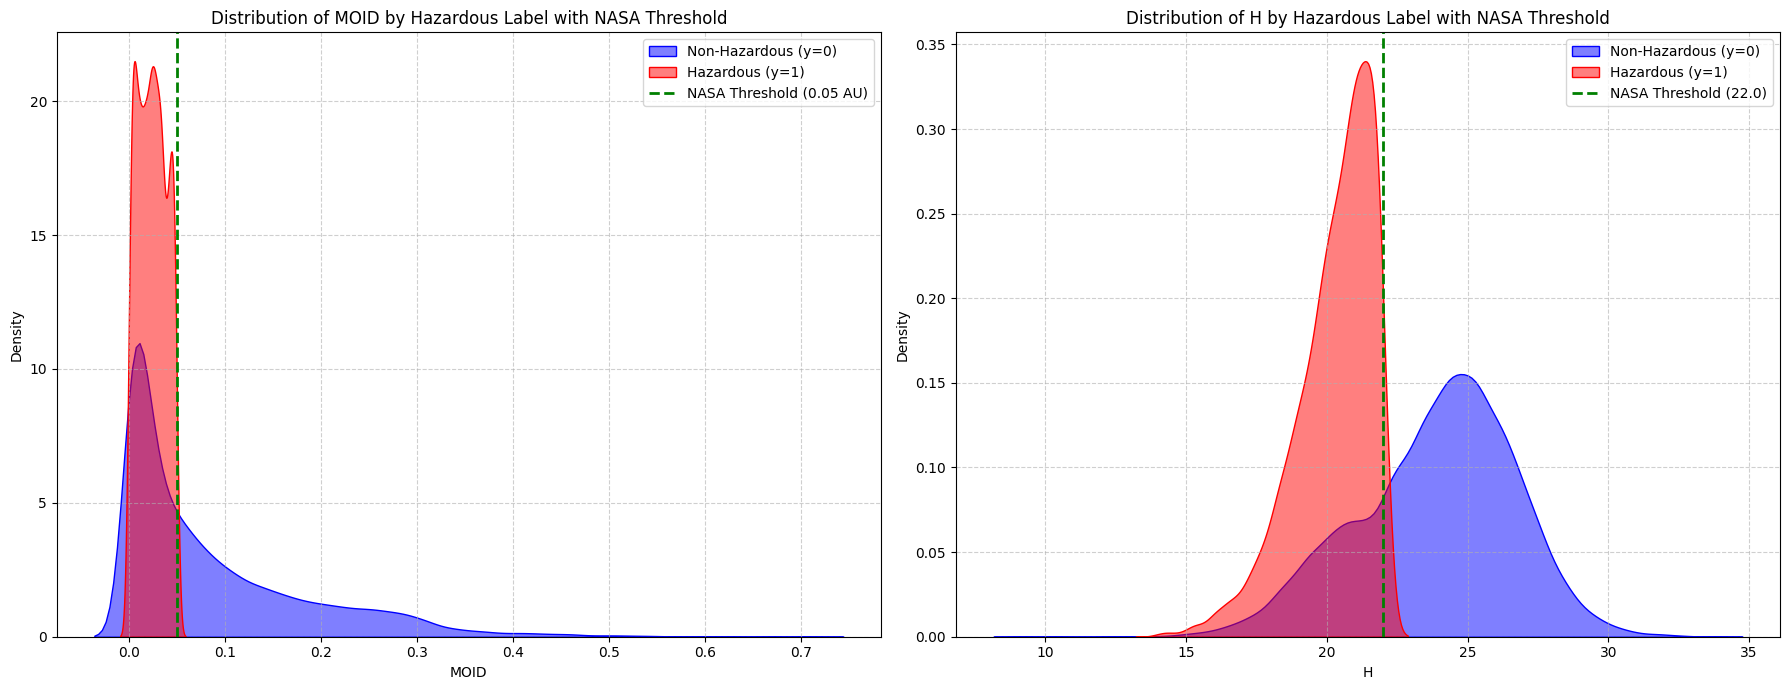

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- First Subplot: Distribution of 'moid' ---

# Separate 'moid' values based on 'hazardous_label'
moid_non_hazardous = X.loc[y == 0, 'moid']
moid_hazardous = X.loc[y == 1, 'moid']

sns.kdeplot(moid_non_hazardous, label='Non-Hazardous (y=0)', fill=True, color='blue', alpha=0.5, ax=axes[0])
sns.kdeplot(moid_hazardous, label='Hazardous (y=1)', fill=True, color='red', alpha=0.5, ax=axes[0])

# Add NASA threshold for 'moid' (MOID <= 0.05 AU)
axes[0].axvline(x=0.05, color='green', linestyle='--', linewidth=2, label='NASA Threshold (0.05 AU)')

axes[0].set_xlabel('MOID')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of MOID by Hazardous Label with NASA Threshold')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# --- Second Subplot: Distribution of 'H' ---

# Separate 'H' values based on 'hazardous_label'
H_non_hazardous = X.loc[y == 0, 'H']
H_hazardous = X.loc[y == 1, 'H']

sns.kdeplot(H_non_hazardous, label='Non-Hazardous (y=0)', fill=True, color='blue', alpha=0.5, ax=axes[1])
sns.kdeplot(H_hazardous, label='Hazardous (y=1)', fill=True, color='red', alpha=0.5, ax=axes[1])

# Add NASA threshold for 'H' (H <= 22.0)
axes[1].axvline(x=22.0, color='green', linestyle='--', linewidth=2, label='NASA Threshold (22.0)')

axes[1].set_xlabel('H')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of H by Hazardous Label with NASA Threshold')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

# Adjust layout and display plots
plt.tight_layout()
plt.show()

## Create a NASA Rule-based Feature

Generate a new binary feature that is 1 if an object meets both NASA criteria ('moid' <= 0.05 and 'H' <= 22.0) and 0 otherwise. This will allow us to quantify the predictive power of the NASA rule.


**Reasoning**:
I need to generate a new binary feature 'nasa_hazardous_rule' in the 'X' DataFrame by applying the specified NASA criteria (moid <= 0.05 and H <= 22.0) and then print its value counts to confirm its distribution.



In [34]:
import numpy as np

# 1. Create a new column 'nasa_hazardous_rule'
# 2. Assign 1 if both conditions are met, 0 otherwise
X['nasa_hazardous_rule'] = np.where(
    (X['moid'] <= 0.05) & (X['H'] <= 22.0),
    1,
    0
)

# 3. Print the value counts of the newly created 'nasa_hazardous_rule'
print("Value counts for 'nasa_hazardous_rule':\n", X['nasa_hazardous_rule'].value_counts())


Value counts for 'nasa_hazardous_rule':
 nasa_hazardous_rule
0    37195
1     2514
Name: count, dtype: int64


## Evaluate NASA Rule's Predictive Power

Calculate the accuracy, precision, recall, and F1-score of this rule-based feature against the actual 'hazardous_label' to quantify its predictive strength. This will provide direct metrics for the NASA rule itself.


**Reasoning**:
To evaluate the predictive power of the 'nasa_hazardous_rule' feature, I will calculate its accuracy, precision, recall, and F1-score against the actual 'hazardous_label' using sklearn.metrics functions.



In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Calculate accuracy
accuracy_nasa_rule = accuracy_score(y, X['nasa_hazardous_rule'])

# 2. Calculate precision
precision_nasa_rule = precision_score(y, X['nasa_hazardous_rule'])

# 3. Calculate recall
recall_nasa_rule = recall_score(y, X['nasa_hazardous_rule'])

# 4. Calculate F1-score
f1_nasa_rule = f1_score(y, X['nasa_hazardous_rule'])

# 5. Print all calculated metrics
print(f"NASA Rule Performance:\n")
print(f"Accuracy: {accuracy_nasa_rule:.4f}")
print(f"Precision: {precision_nasa_rule:.4f}")
print(f"Recall: {recall_nasa_rule:.4f}")
print(f"F1-Score: {f1_nasa_rule:.4f}")

NASA Rule Performance:

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


## Remove Leaky Fetaures and NASA Rule


In [36]:
X.drop(columns=['moid', 'H','moid_ld'], axis=1, inplace=True)
print("Shape of X after removing 'moid' and 'H':", X.shape)

Shape of X after removing 'moid' and 'H': (39709, 4167)


In [37]:

columns_to_remove = []
if 'nasa_hazardous_rule' in X.columns:
    columns_to_remove.append('nasa_hazardous_rule')
if 'risk_score' in X.columns:
    columns_to_remove.append('risk_score')

if columns_to_remove:
    X.drop(columns=columns_to_remove, axis=1, inplace=True)
print("Shape of X after removing 'nasa_hazardous_rule' and 'risk_score':", X.shape)


Shape of X after removing 'nasa_hazardous_rule' and 'risk_score': (39709, 4165)


In [38]:
X.columns

Index(['sats', 'diameter', 'albedo', 'rot_per', 'epoch', 'e', 'a', 'q', 'i',
       'om',
       ...
       'epoch_cal_2025-10-16.0000000', 'epoch_cal_2025-10-17.0000000',
       'epoch_cal_2025-10-18.0000000', 'epoch_cal_2025-10-19.0000000',
       'epoch_cal_2025-10-20.0000000', 'epoch_cal_2025-10-21.0000000',
       'epoch_cal_2025-11-21.0000000', 'class_APO', 'class_ATE', 'class_IEO'],
      dtype='object', length=4165)

In [39]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# Use a test size of 20% and a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("Data re-splitting complete.")

X_train shape: (31767, 4165)
X_test shape: (7942, 4165)
y_train shape: (31767,)
y_test shape: (7942,)
Data re-splitting complete.


In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Instantiate a RandomForestClassifier model
model = RandomForestClassifier(random_state=42)

model.fit(X_train, y_train)

print("RandomForestClassifier model retrained successfully after feature removal.")

# 1. Use the retrained model to make predictions on the X_test dataset
y_pred_retrained = model.predict(X_test)

# 2. Use the retrained model to predict probabilities for the positive class
y_pred_proba_retrained = model.predict_proba(X_test)[:, 1]

# 3. Calculate key classification metrics for the retrained model
accuracy_retrained = accuracy_score(y_test, y_pred_retrained)
precision_retrained = precision_score(y_test, y_pred_retrained)
recall_retrained = recall_score(y_test, y_pred_retrained)
f1_retrained = f1_score(y_test, y_pred_retrained)
roc_auc_retrained = roc_auc_score(y_test, y_pred_proba_retrained)

# 4. Print all calculated metrics
print(f"\nRe-evaluated Model Performance on Test Set (without MOID, H, moid_ld, nasa_hazardous_rule, and risk_score):\n")
print(f"Accuracy: {accuracy_retrained:.4f}")
print(f"Precision: {precision_retrained:.4f}")
print(f"Recall: {recall_retrained:.4f}")
print(f"F1-Score: {f1_retrained:.4f}")
print(f"ROC AUC Score: {roc_auc_retrained:.4f}")


RandomForestClassifier model retrained successfully after feature removal.

Re-evaluated Model Performance on Test Set (without MOID, H, moid_ld, nasa_hazardous_rule, and risk_score):

Accuracy: 0.9442
Precision: 0.7679
Recall: 0.1710
F1-Score: 0.2797
ROC AUC Score: 0.9599


## Adjust Classification Threshold


In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define a range of classification thresholds
thresholds = np.arange(0.1, 1.0, 0.1)

# 2. Initialize variables to keep track of the best metrics
best_recall = -1
best_precision = -1
best_f1 = -1
best_accuracy = -1
best_threshold = -1
best_y_pred_thresholded = np.zeros_like(y_test) # Initialize with zeros

print("Evaluating performance across different thresholds:\n")

# 3. Iterate through each threshold
for threshold in thresholds:
    # a. Generate new binary predictions based on the current threshold
    y_pred_thresholded = (y_pred_proba_retrained >= threshold).astype(int)

    # b. Calculate the metrics for the current threshold
    accuracy = accuracy_score(y_test, y_pred_thresholded)
    # Set zero_division=0 to handle cases where there are no predicted positive samples
    precision = precision_score(y_test, y_pred_thresholded, zero_division=0)
    recall = recall_score(y_test, y_pred_thresholded, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresholded, zero_division=0)

    # c. Print the current threshold and its corresponding calculated metrics
    print(f"Threshold: {threshold:.1f}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

    # d. Update best metrics if current threshold yields better recall with reasonable precision
    # Define 'reasonable precision' - for example, greater than 0.5
    if recall > best_recall and precision > 0.5:
        best_recall = recall
        best_precision = precision
        best_f1 = f1
        best_accuracy = accuracy
        best_threshold = threshold
        best_y_pred_thresholded = y_pred_thresholded
    print("\n")

Evaluating performance across different thresholds:

Threshold: 0.1
  Accuracy: 0.8630
  Precision: 0.3104
  Recall: 0.9523
  F1-Score: 0.4682


Threshold: 0.2
  Accuracy: 0.9140
  Precision: 0.4125
  Recall: 0.8429
  F1-Score: 0.5539


Threshold: 0.3
  Accuracy: 0.9425
  Precision: 0.5395
  Recall: 0.6243
  F1-Score: 0.5788


Threshold: 0.4
  Accuracy: 0.9491
  Precision: 0.6542
  Recall: 0.4175
  F1-Score: 0.5097


Threshold: 0.5
  Accuracy: 0.9449
  Precision: 0.7600
  Recall: 0.1889
  F1-Score: 0.3025


Threshold: 0.6
  Accuracy: 0.9397
  Precision: 0.8333
  Recall: 0.0596
  F1-Score: 0.1113


Threshold: 0.7
  Accuracy: 0.9368
  Precision: 1.0000
  Recall: 0.0020
  F1-Score: 0.0040


Threshold: 0.8
  Accuracy: 0.9367
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000


Threshold: 0.9
  Accuracy: 0.9367
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000




In [42]:
# 4. Print the metrics for the selected best threshold
print("--- Best Threshold Performance (Highest Recall with Precision > 0.5) ---")
# Handle case where no threshold met the precision criteria
if best_threshold == -1:
    print("No threshold found that satisfies precision > 0.5. Defaulting to original model predictions.")
    # Optionally, revert to the original predictions if no better threshold is found
    best_y_pred_thresholded = (y_pred_proba_retrained >= 0.5).astype(int) # Default to 0.5 threshold
    best_accuracy = accuracy_score(y_test, best_y_pred_thresholded)
    best_precision = precision_score(y_test, best_y_pred_thresholded, zero_division=0)
    best_recall = recall_score(y_test, best_y_pred_thresholded, zero_division=0)
    best_f1 = f1_score(y_test, best_y_pred_thresholded, zero_division=0)
    best_threshold = 0.5 # Indicate default threshold

print(f"Selected Threshold: {best_threshold:.1f}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall: {best_recall:.4f}")
print(f"F1-Score: {best_f1:.4f}")
print("\n")

--- Best Threshold Performance (Highest Recall with Precision > 0.5) ---
Selected Threshold: 0.3
Accuracy: 0.9425
Precision: 0.5395
Recall: 0.6243
F1-Score: 0.5788




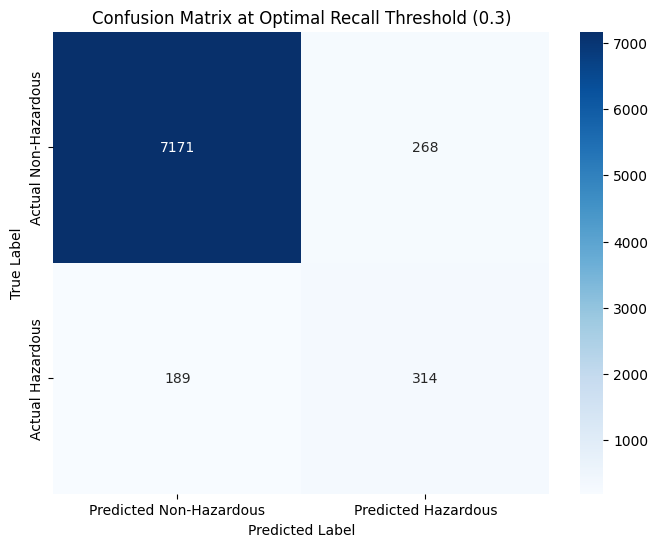

In [43]:
# 5. Compute the confusion matrix using the selected best threshold
cm_best_threshold = confusion_matrix(y_test, best_y_pred_thresholded)

# 6. Create a heatmap of this confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_threshold, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Non-Hazardous', 'Predicted Hazardous'],
            yticklabels=['Actual Non-Hazardous', 'Actual Hazardous'])

# 7. Add labels and title and display the plot
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix at Optimal Recall Threshold ({best_threshold:.1f})')
plt.show()

## Implement Class Imbalance Handling (SMOTE)

Address potential class imbalance in the training data. Apply an oversampling technique like SMOTE (Synthetic Minority Over-sampling Technique) to the training set (`X_train`, `y_train`) to balance the classes, then retrain the model and evaluate its performance.


In [44]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# 1. & 2. Instantiate SMOTE with a random state
smote = SMOTE(random_state=42)

print("Original training data class distribution:")
print(y_train.value_counts())
print(f"Original X_train shape: {X_train.shape}")

# 3. Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 4. Print the shape of the original and SMOTE-augmented training data
print("\nSMOTE-augmented training data class distribution:")
print(y_train_smote.value_counts())
print(f"SMOTE-augmented X_train shape: {X_train_smote.shape}")

# 5. Instantiate a new RandomForestClassifier model
model_smote = RandomForestClassifier(random_state=42)

# 6. Train this new model using the SMOTE-augmented training data
model_smote.fit(X_train_smote, y_train_smote)

print("\nRandomForestClassifier model retrained successfully with SMOTE data.")

# 7. Use the trained model to make predictions and predict probabilities on the original X_test dataset
y_pred_smote = model_smote.predict(X_test)
y_pred_proba_smote = model_smote.predict_proba(X_test)[:, 1]

# 8. Calculate and print key classification metrics
accuracy_smote = accuracy_score(y_test, y_pred_smote)
precision_smote = precision_score(y_test, y_pred_smote, zero_division=0)
recall_smote = recall_score(y_test, y_pred_smote, zero_division=0)
f1_smote = f1_score(y_test, y_pred_smote, zero_division=0)
roc_auc_smote = roc_auc_score(y_test, y_pred_proba_smote)

print(f"\nModel Performance on Test Set (after SMOTE retraining):\n")
print(f"Accuracy: {accuracy_smote:.4f}")
print(f"Precision: {precision_smote:.4f}")
print(f"Recall: {recall_smote:.4f}")
print(f"F1-Score: {f1_smote:.4f}")
print(f"ROC AUC Score: {roc_auc_smote:.4f}")

Original training data class distribution:
hazardous_label
0    29756
1     2011
Name: count, dtype: int64
Original X_train shape: (31767, 4165)

SMOTE-augmented training data class distribution:
hazardous_label
0    29756
1    29756
Name: count, dtype: int64
SMOTE-augmented X_train shape: (59512, 4165)

RandomForestClassifier model retrained successfully with SMOTE data.

Model Performance on Test Set (after SMOTE retraining):

Accuracy: 0.9252
Precision: 0.4455
Recall: 0.7396
F1-Score: 0.5561
ROC AUC Score: 0.9566


In [45]:
import joblib
# Save model and feature columns
models_dir = os.path.join(os.getcwd(), '..', 'models')
os.makedirs(models_dir, exist_ok=True)
model_path = os.path.join(models_dir, 'random_forest_smote.pkl')
joblib.dump(model_smote, model_path)
# Save feature list to allow consistent preprocessing when using the model
import json
with open(os.path.join(models_dir, 'rf_features.json'), 'w') as fh:
    json.dump({'features': X.columns.tolist()}, fh)

print(f"\nRandom Forest model saved to: {model_path}")


Random Forest model saved to: c:\Users\mail2\Desktop\Boston\Sem 1\CS 506 DS\Project\CS506_Project\Notebooks\..\models\random_forest_smote.pkl
